# Example 2 : Getting MUSIC traces

In this notebook, we will perform some basic analysis to get some potential fusion traces to look at. Building off what we learned in example 1, we will use the test MUSIC data and then show a few different methods to build a panda's dataframe from the ROOT file. Since the test data file is fairly small in size (~ 18 MB), we can do this all in memory. However, for larger files, it is often best to do the ROOT to dataframe conversion once and then save the dataframe as some type of panda's readable formatted file (we will look at this in the next example). First, let's set up our notebook.  

In [1]:
import uproot
import pandas as pd
import numpy as np
import matplotlib as mpl

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.dpi'] = 200 # bigger figures

# Use more REVTEX-esque fonts
mpl.rcParams["font.family"] = "serif"
mpl.rcParams["font.serif"] = "STIXGeneral"
mpl.rcParams["mathtext.fontset"] = "stix"

Now, we open the ROOT file, grab the tree, and convert the branches to arrays. Remember back to example 1, our arrays are awkward arrays not numpy arrays. However, awkward arrays are designed to have "similar" behavior as numpy arrays (with some minor differences). For example, with numpy arrays you can independently get the shape of the array or the datatype (dtype) of each of the variables stored in the array. With an awkward array, this has been combined into a "type" attribute.

In [59]:
file = uproot.open("test_music_data.root")
tree = file['tree']
branches = tree.arrays()

print(branches.type)
print()
branches.type?

4285264 * {"edepl": float32, "edepr": float32, "seg": int32, "regl": int32, "regr": int32, "cath": float32, "grid": float32, "strip0": float32, "strip17": float32, "tac": float32}



Type:        property
String form: <property object at 0x000002DD053934F0>
Docstring:  
The high-level type of this Array; same as #ak.type.

Note that the outermost element of an Array's type is always an
#ak.types.ArrayType, which specifies the number of elements in the array.

The type of a #ak.layout.Content (from #ak.Array.layout) is not
wrapped by an #ak.types.ArrayType.

## What if you want to store the data in a different form?

One of the strengths of using python is the ecosystem of packages and libraries. When working with structured datasets (similar to what we have, a set of variables and values), two common ways of "storing" the data for manipulation in python are numpy arrays and pandas dataframes. I prefer working with pandas dataframes, and that is what I will be using in the examples to follow. However, it is very easy to move from one to the other. In addition, either one can be written to disk, so no need to do everything in memory. So, let's take a short tangent and see how easy it is to convert these awkward arrays to either numpy arrays or a dataframe. 

<div class="alert alert-block alert-info">
You may have noticed the structure of the data looks a little weird from what you might expect. If you've taken a look at strip0 or strip17, then you know what I'm getting at. This is just how the analog DAQ data was stored. We will address this in more detail a little later on in this notebook.
</div>

### Convert Awkward array to a NumPy array

Since we are dealing with a rectangular array, we could just convert our awkward array into a numpy array. Awkward has a function to do that. 

In [32]:
import awkward as ak

np_branches = ak.to_numpy(branches)

print(type(np_branches))
print('Which has ' + str(np_branches.size) + ' elements')
print(np_branches.dtype)

<class 'numpy.ndarray'>
Which has 4285264 elements
[('edepl', '<f4'), ('edepr', '<f4'), ('seg', '<i4'), ('regl', '<i4'), ('regr', '<i4'), ('cath', '<f4'), ('grid', '<f4'), ('strip0', '<f4'), ('strip17', '<f4'), ('tac', '<f4')]


You could, if you wanted to, stop here. One advantage of using a numpy array rather than leaving the data as an awkward array is avoiding edge cases where awkward arrays do not work properly with other bits of bespoke python code. This is more of an issue if someone assumes the awkward array is a true numpy array. Say you wanted to share the data with a colleague who uses python or what if you wanted your analysis code to only use "standard" python packages (like matplotlib, numpy, scipy, seaborn etc...) using a cloud based jupyter notebook. In that case, since most python users will have some familiarity with maniplating numpy arrays you can just give them a copy of the numpy array and save potential hassle. Accessing the data as either the awkward array or numpy array in most cases is identical, so this is more a matter of preference rather than anything else. For example, if you wanted to get the first entry for the energy deposited in strip L1 you can do so with

In [123]:
print(type(branches))
print('First entry of strip L1 from Awkward array = ' + str(branches['edepl'][0]))
print(type(np_branches))
print('First entry of strip L1 from NumPy array = ' + str(np_branches['edepl'][0]))

<class 'awkward.highlevel.Array'>
First entry of strip L1 from Awkward array = 366.0
<class 'numpy.ndarray'>
First entry of strip L1 from NumPy array = 366.0


If you wanted to write the numpy array to a npy file, you can do
```python
np.save('test_numpy_array.npy', np_branches)

```
and you can load the saved array with
```python
load_np_branches = np.load('test_numpy_array.npy')
```

We could use the numpy array to build a pandas dataframe by creating a dictionary.

In [170]:
dict_branches = {}

for name in np_branches.dtype.names:
    dict_branches.update({name: np_branches[name]})
    
dict_branches

{'edepl': array([366.,  35., 387., ...,  38., 457.,  43.], dtype=float32),
 'edepr': array([ 50., 366.,  33., ..., 479.,  32., 469.], dtype=float32),
 'seg': array([ 1,  2,  3, ..., 14, 15, 16]),
 'regl': array([ 5,  7,  9, ..., 31, 33, 35]),
 'regr': array([ 6,  8, 10, ..., 32, 34, 36]),
 'cath': array([358., 358., 358., ..., 358., 358., 358.], dtype=float32),
 'grid': array([1522., 1522., 1522., ..., 1563., 1563., 1563.], dtype=float32),
 'strip0': array([1003., 1003., 1003., ...,  953.,  953.,  953.], dtype=float32),
 'strip17': array([402., 402., 402., ..., 387., 387., 387.], dtype=float32),
 'tac': array([712., 712., 712., ..., 710., 710., 710.], dtype=float32)}

And now building a pandas dataframe from the dictionary.

In [174]:
df_branches = pd.DataFrame(dict_branches)

df_branches

,edepl,edepr,seg,regl,regr,cath,grid,strip0,strip17,tac
0,366.0,50.0,1,5,6,358.0,1522.0,1003.0,402.0,712.0
1,35.0,366.0,2,7,8,358.0,1522.0,1003.0,402.0,712.0
2,387.0,33.0,3,9,10,358.0,1522.0,1003.0,402.0,712.0
3,42.0,335.0,4,11,12,358.0,1522.0,1003.0,402.0,712.0
4,377.0,33.0,5,13,14,358.0,1522.0,1003.0,402.0,712.0
...,...,...,...,...,...,...,...,...,...,...
4285259,36.0,455.0,12,27,28,358.0,1563.0,953.0,387.0,710.0
4285260,419.0,37.0,13,29,30,358.0,1563.0,953.0,387.0,710.0
4285261,38.0,479.0,14,31,32,358.0,1563.0,953.0,387.0,710.0
4285262,457.0,32.0,15,33,34,358.0,1563.0,953.0,387.0,710.0


Now we can clearly see how the data is formatted. Each row is not an individual event; the rows are simply entries. We can see from the above preview rendered by the notebook that there are repeating values in the cath, grid, strip0, strip17 and tac columns. Looking at the seg column it is clear what is going on. Each event is stored as a 16 x 10 block of data. The 16 rows correspond to the 16 left and right segments of the anode (the edepl and edepr columns) so we just repeat the entries which should be single-valued (like strip0) 16 times so the columns are all the same length. 

Another way to format the data would be to have each row correspond to one event, with the columns corresponding to the anode strips. Let's build a dataframe from the arrays but enforce this format.

### Convert Awkward array to a Formatted DataFrame (one event per row)

There are a few different ways we could build a dataframe with the format we want. However, uproot has the ability to apply "masks". These can be used to apply cuts to data or enforce a selection using equality or inequality symbols. If you wanted to make a histogram of the energy deposited only in strip L1 (the first part of the segmented anode that the beam passes through) you could apply a mask that would restrict the values of edepl to only those with seg == 1. The mask works much the same as slicing arrays in general, so to do the previously mentioned histogram of strip L1 we can do 

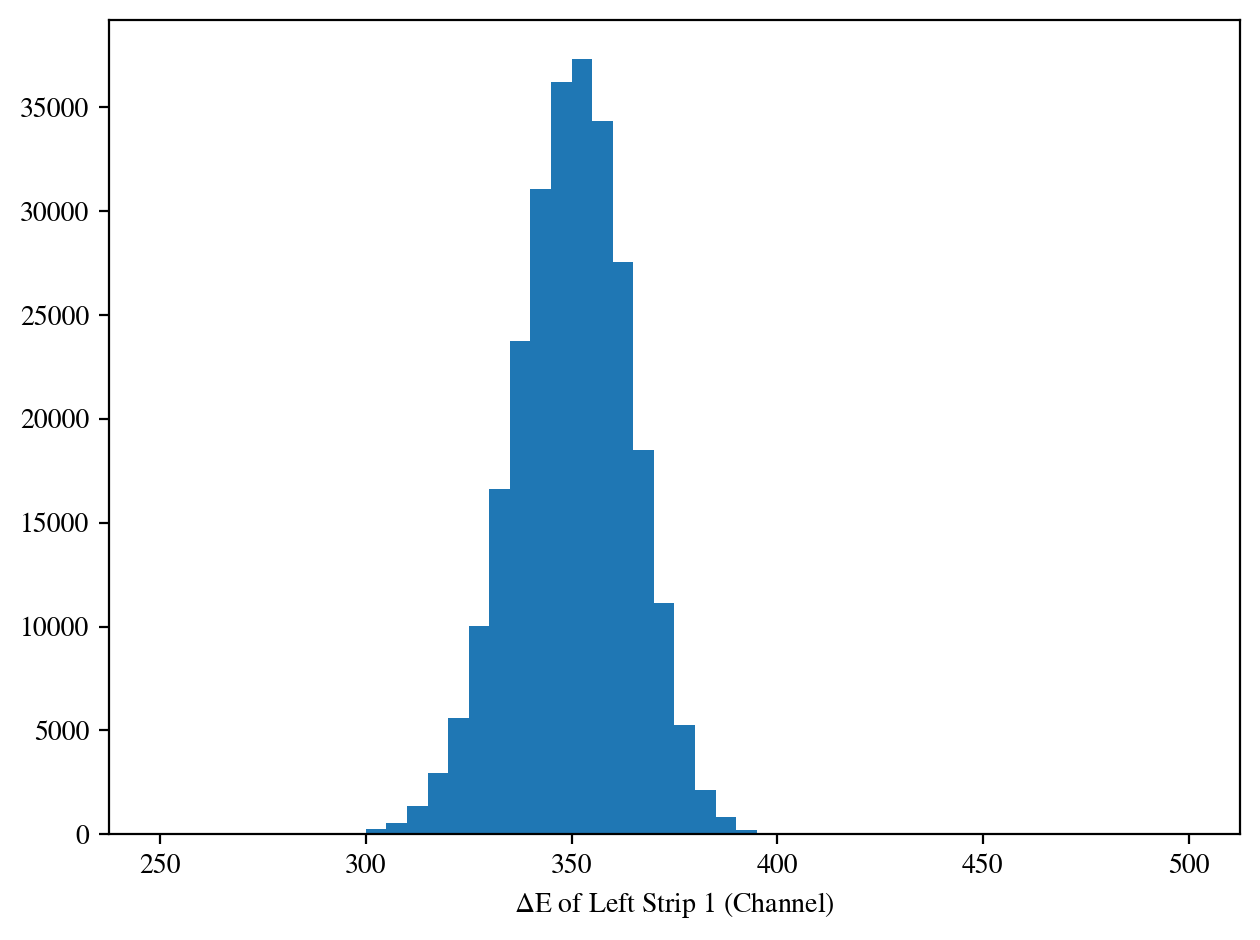

In [198]:
left_strip1 = branches['edepl'][branches['seg'] == 1] 

plt.hist(left_strip1,
         bins=50,
         range=[250,500])

plt.xlabel(r'$\Delta$E of Left Strip 1 (Channel)')

plt.tight_layout()
plt.show()

Using a mask, we can also double-check that the columns which should be single-valued (like strip0) are populated using 16 copies of the strip0 value of that event (thus ensuring all the columns have the same size).

In [199]:
len(branches['strip0']) // len(branches['strip0'][branches['seg'] == 1])

16

Now, similar to what we did in the last section, we start by building a dictionary with the values and keys from the awkward array. Using masks, we ensure we are only getting one copy of strip0 and strip17 in addition to building the segmented anode as separate columns.

In [185]:
dict_branches = {}

# strip0 first
dict_branches.update({'s0':branches['strip0'][branches['seg'] == 1]})
# segmented anode, left first then right
for i in range(1,17):
    dict_branches.update({'s%iL' % i : branches['edepl'][branches['seg'] == i]})
    dict_branches.update({'s%iR' % i  : branches['edepr'][branches['seg'] == i]})
# strip17 last
dict_branches.update({'s17':branches['strip17'][branches['seg'] == 1]})
    
dict_branches

{'s0': <Array [1e+03, 1.09e+03, ... 1.01e+03, 953] type='267829 * float32'>,
 's1L': <Array [366, 356, 364, 362, ... 327, 344, 339] type='267829 * float32'>,
 's1R': <Array [50, 41, 62, 43, 41, ... 41, 49, 39, 43] type='267829 * float32'>,
 's2L': <Array [35, 37, 36, 37, 37, ... 36, 40, 41, 37] type='267829 * float32'>,
 's2R': <Array [366, 366, 359, 341, ... 355, 330, 361] type='267829 * float32'>,
 's3L': <Array [387, 376, 371, 359, ... 362, 395, 360] type='267829 * float32'>,
 's3R': <Array [33, 32, 35, 35, 33, ... 35, 32, 35, 34] type='267829 * float32'>,
 's4L': <Array [42, 36, 38, 37, 39, ... 36, 37, 36, 36] type='267829 * float32'>,
 's4R': <Array [335, 361, 372, 380, ... 361, 364, 385] type='267829 * float32'>,
 's5L': <Array [377, 368, 365, 411, ... 401, 419, 379] type='267829 * float32'>,
 's5R': <Array [33, 30, 29, 30, 30, ... 38, 31, 28, 37] type='267829 * float32'>,
 's6L': <Array [39, 37, 37, 39, 38, ... 41, 35, 37, 39] type='267829 * float32'>,
 's6R': <Array [372, 399, 

In [190]:
df_branches = pd.DataFrame(dict_branches)

df_branches

,s0,s1L,s1R,s2L,s2R,s3L,s3R,s4L,s4R,s5L,...,s12R,s13L,s13R,s14L,s14R,s15L,s15R,s16L,s16R,s17
0,1003.0,366.0,50.0,35.0,366.0,387.0,33.0,42.0,335.0,377.0,...,461.0,463.0,34.0,35.0,457.0,462.0,33.0,49.0,445.0,402.0
1,1091.0,356.0,41.0,37.0,366.0,376.0,32.0,36.0,361.0,368.0,...,432.0,429.0,37.0,41.0,522.0,470.0,32.0,40.0,482.0,380.0
2,1083.0,364.0,62.0,36.0,359.0,371.0,35.0,38.0,372.0,365.0,...,451.0,447.0,37.0,38.0,501.0,471.0,32.0,39.0,483.0,402.0
3,1002.0,362.0,43.0,37.0,341.0,359.0,35.0,37.0,380.0,411.0,...,471.0,436.0,36.0,37.0,442.0,470.0,33.0,37.0,467.0,400.0
4,1015.0,352.0,41.0,37.0,361.0,377.0,33.0,39.0,382.0,409.0,...,445.0,444.0,33.0,37.0,441.0,442.0,34.0,43.0,463.0,366.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
267824,1040.0,338.0,63.0,36.0,360.0,381.0,37.0,36.0,377.0,419.0,...,459.0,425.0,39.0,33.0,434.0,419.0,35.0,39.0,459.0,403.0
267825,969.0,325.0,41.0,36.0,360.0,387.0,35.0,36.0,363.0,406.0,...,436.0,437.0,38.0,36.0,460.0,448.0,34.0,38.0,479.0,384.0
267826,958.0,327.0,49.0,40.0,355.0,362.0,32.0,37.0,361.0,401.0,...,437.0,423.0,36.0,34.0,447.0,420.0,36.0,46.0,451.0,398.0
267827,1006.0,344.0,39.0,41.0,330.0,395.0,35.0,36.0,364.0,419.0,...,437.0,436.0,35.0,39.0,459.0,456.0,33.0,53.0,389.0,393.0


And we now have our dataframe in a very straightforward format. Each row corresponds to a recorded event. For a given row, the columns give the recorded $\Delta$E for that strip. Accessing from the dataframe is much like the numpy or awkward arrays. For example the $\Delta$E of the first event in strip 1L

In [211]:
print('From Awkward array ' + str(branches['edepl'][branches['seg'] == 1][0]))
print('From our event DataFrame ' + str(df_branches['s1L'][0]))

From Awkward array 366.0
From our event DataFrame 366.0


## Looking at Traces

With our dataframe set up, let's plot some traces. The first thing to point out is we have not normalized any of our data yet. In principle, since this is all from the same run, you might not think this is an issue. However, for most MUSIC experiments strip0 and strip17 are on their own preamps. For the middle 16 strips, the left and right sides are on their own preamps. So, differences in gain need to be accounted for. We will address this in the next example notebook. For the moment we will just look at the middle 16 strips (fusion signals are so large compared to beam that the difference in gain between the left and right sides won't be a big issue for this quick look). 

There are many ways to plot the data from our dataframe. Since we just want the middle 16 strips, we want to sum over the left and right (just look at the sum to start). If we don't want to modify the dataframe, we can make a helper function to set things up for plotting.

In [234]:
def seg_trace(df, event):
    ''' Helper function to sum over middle anode strips.
    
    Parameters
    ----------
    df : dataframe
        Dataframe containing the full data strip 0 - 17.
    event : int
        Event to collect trace information for.
            
    Returns
    -------
    out : array
        Array of strips 1-16 summed over left and right.
    '''
    trace_array = []
    for i in range(1,32,2):
        trace_array.append(df.iloc[event,i] + df.iloc[event,i+1])
    return trace_array

Now let's plot the first 10 traces and see what things look like.

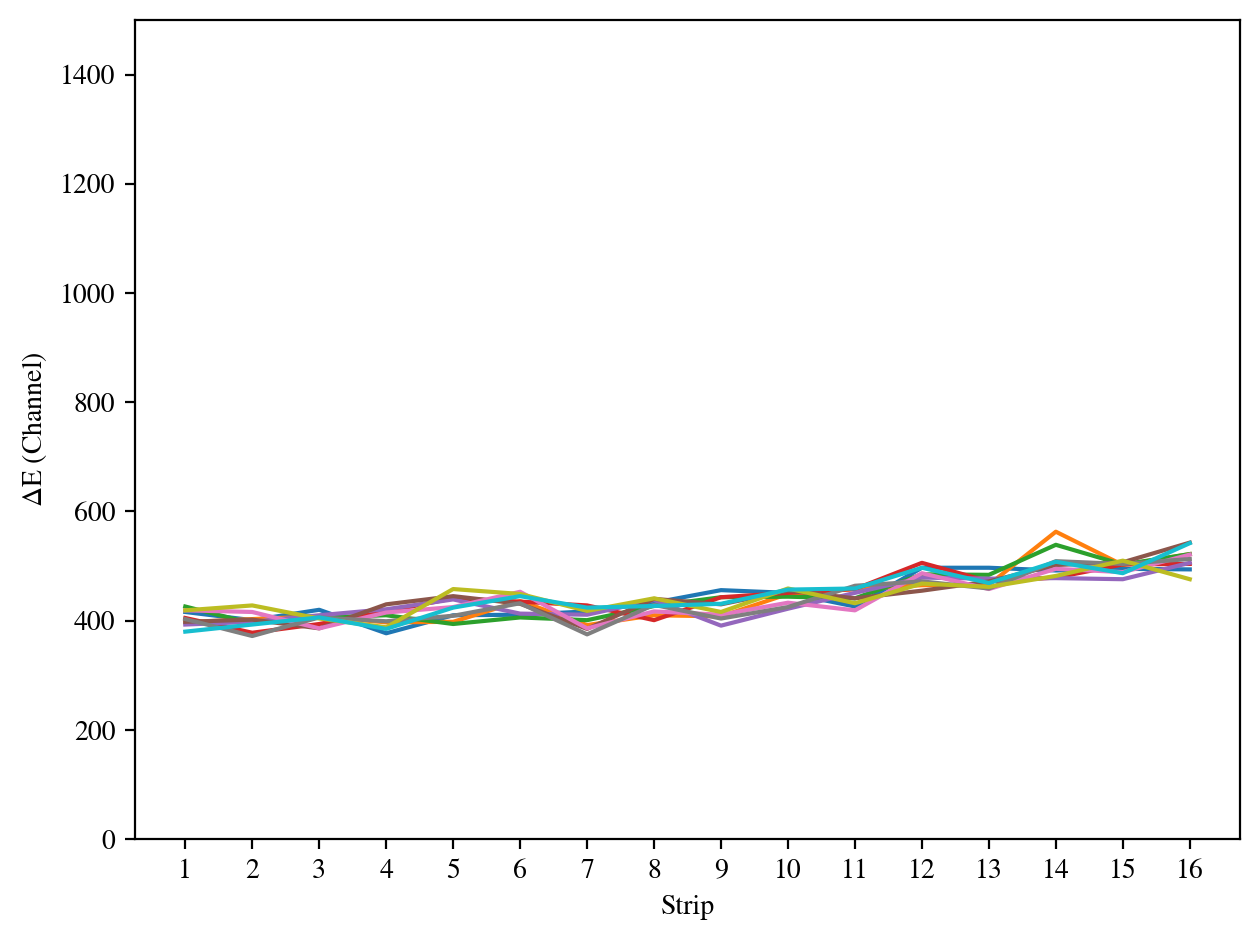

In [235]:
for i in range(10):
    plt.plot(seg_trace(df_branches, i))
    
plt.xlabel('Strip')
# tick marks line up with correct strip number
plt.xticks(ticks=range(0,16),
           labels=(str(i) for i in range(1,17)))
plt.ylabel(r'$\Delta$E (Channel)')
plt.ylim(0,1500)

plt.tight_layout()
plt.show()

Not surprisingly, we have plotted the most likely kind of trace (beam). Note that if we didn't force the large y-axis limits, you would get zoomed-in traces, which at first glance look weird (until you zoom out, that is). Earlier in this notebook we used a mask to make cuts on the awkward arrays. We can do a similar thing with our dataframe. Again, we will get more into identifying events in the next example. However, we can use our general knowledge about how MUSIC records signals to come up with some cuts.

MUSIC as an ionization chamber records signals which correspond to the energy loss of particles moving inside the target gas. The energy loss of the heavy ions through the target gas is proportional to the square of the charge of the heavy ion (there is also dependence on energy, but changes in Z are much more prominent). Then, a fusion event will create a heavy ion with a much larger Z than the beam. So, we want to find events where we see a jump in the trace signal. In the above plot, beam-like events appear to hover around channels 400 - 500. Lets apply a cut in strip 5 where we only want to look at events with a $\Delta$E in strip 5 left (the long strip that the beam passes through) with channel > 800. But, we must be midful, we want fusions resuling from our beam not pileup or contaminants. So we will also apply an extra cut that the trace must be beam like in strip L3 (s3L must be less than, say, 600). As it might be nice to keep the original dataframe, we will use the pandas drop function to create a copy of our dataframe with events fitting the above two cuts.

In [260]:
# Note here the usage of the drop function. It seems backward at first, but checking the 
# dockstring the binary operator is the right way round
strip_5_test = df_branches.drop(df_branches[800 > df_branches.s5L].index,
                                inplace=False)
strip_5_test.drop(strip_5_test[strip_5_test.s3L > 600].index,
                                inplace=True)


strip_5_test.describe()

,s0,s1L,s1R,s2L,s2R,s3L,s3R,s4L,s4R,s5L,...,s12R,s13L,s13R,s14L,s14R,s15L,s15R,s16L,s16R,s17
count,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,...,3.000000,3.000000,3.000000,3.000000,3.0,3.0,3.000000,3.000000,3.000000,3.000000
mean,1027.333374,356.000000,55.333332,35.666668,365.000000,411.333344,38.333332,38.666668,711.333313,923.000000,...,57.000000,36.333332,37.333332,37.333332,39.0,38.0,33.666668,39.666668,38.666668,38.666668
std,47.077950,12.288206,6.658329,1.154701,17.320509,55.012123,7.571877,1.154701,270.489075,55.217751,...,34.655445,1.527525,0.577350,1.527525,2.0,1.0,1.154701,2.081666,1.154701,5.131601
min,993.000000,342.000000,51.000000,35.000000,355.000000,371.000000,33.000000,38.000000,399.000000,860.000000,...,36.000000,35.000000,37.000000,36.000000,37.0,37.0,33.000000,38.000000,38.000000,33.000000
25%,1000.500000,351.500000,51.500000,35.000000,355.000000,380.000000,34.000000,38.000000,633.000000,903.000000,...,37.000000,35.500000,37.000000,36.500000,38.0,37.5,33.000000,38.500000,38.000000,36.500000
50%,1008.000000,361.000000,52.000000,35.000000,355.000000,389.000000,35.000000,38.000000,867.000000,946.000000,...,38.000000,36.000000,37.000000,37.000000,39.0,38.0,33.000000,39.000000,38.000000,40.000000
75%,1044.500000,363.000000,57.500000,36.000000,370.000000,431.500000,41.000000,39.000000,867.500000,954.500000,...,67.500000,37.000000,37.500000,38.000000,40.0,38.5,34.000000,40.500000,39.000000,41.500000
max,1081.000000,365.000000,63.000000,37.000000,385.000000,474.000000,47.000000,40.000000,868.000000,963.000000,...,97.000000,38.000000,38.000000,39.000000,41.0,39.0,35.000000,42.000000,40.000000,43.000000


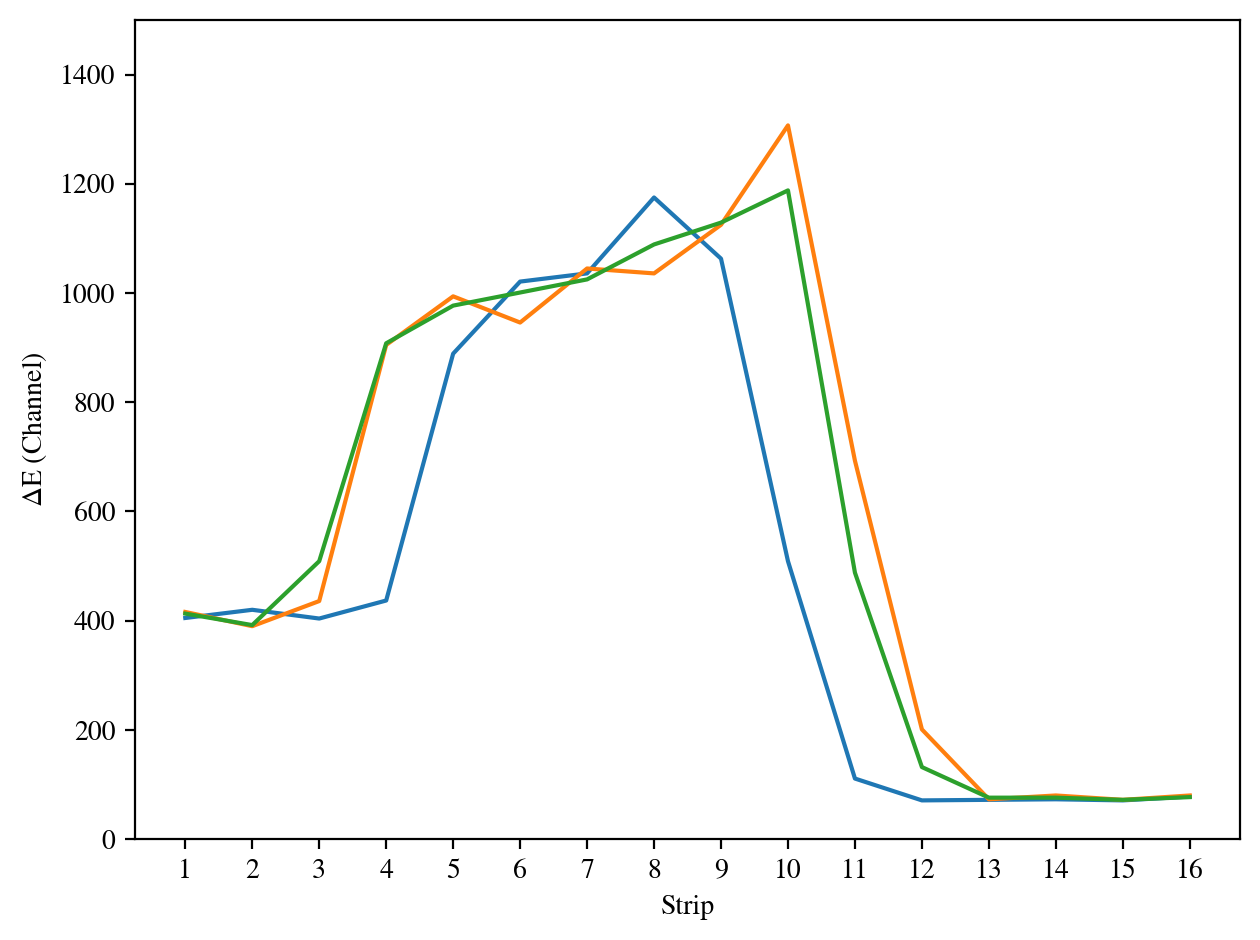

In [263]:
if len(strip_5_test.index) > 10:
    number = 10
else:
    number = len(strip_5_test.index)

for i in range(number):
    plt.plot(seg_trace(strip_5_test, i))
    
plt.xlabel('Strip')
# tick marks line up with correct strip number
plt.xticks(ticks=range(0,16),
           labels=(str(i) for i in range(1,17)))
plt.ylabel(r'$\Delta$E (Channel)')
plt.ylim(0,1500)

plt.tight_layout()
plt.show()

## Saving DataFrame to Feather

Now that we have our formatted dataframe setup, we can save the dataframe to disk. Here, we will use the [Apache Arrow](https://arrow.apache.org/docs/python/) format, a binary file format with compression. Pandas has a function to export a dataframe (with index and column labels) to this format, as long as you have installed pyarrow you can easily save a feather file using this format. To save our dataframe we do

In [264]:
df_branches.to_feather('test_music_data.feather')

If you want to load a feather file back into a dataframe we can do

In [265]:
load_df_branches = pd.read_feather('test_music_data.feather')

load_df_branches

,s0,s1L,s1R,s2L,s2R,s3L,s3R,s4L,s4R,s5L,...,s12R,s13L,s13R,s14L,s14R,s15L,s15R,s16L,s16R,s17
0,1003.0,366.0,50.0,35.0,366.0,387.0,33.0,42.0,335.0,377.0,...,461.0,463.0,34.0,35.0,457.0,462.0,33.0,49.0,445.0,402.0
1,1091.0,356.0,41.0,37.0,366.0,376.0,32.0,36.0,361.0,368.0,...,432.0,429.0,37.0,41.0,522.0,470.0,32.0,40.0,482.0,380.0
2,1083.0,364.0,62.0,36.0,359.0,371.0,35.0,38.0,372.0,365.0,...,451.0,447.0,37.0,38.0,501.0,471.0,32.0,39.0,483.0,402.0
3,1002.0,362.0,43.0,37.0,341.0,359.0,35.0,37.0,380.0,411.0,...,471.0,436.0,36.0,37.0,442.0,470.0,33.0,37.0,467.0,400.0
4,1015.0,352.0,41.0,37.0,361.0,377.0,33.0,39.0,382.0,409.0,...,445.0,444.0,33.0,37.0,441.0,442.0,34.0,43.0,463.0,366.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
267824,1040.0,338.0,63.0,36.0,360.0,381.0,37.0,36.0,377.0,419.0,...,459.0,425.0,39.0,33.0,434.0,419.0,35.0,39.0,459.0,403.0
267825,969.0,325.0,41.0,36.0,360.0,387.0,35.0,36.0,363.0,406.0,...,436.0,437.0,38.0,36.0,460.0,448.0,34.0,38.0,479.0,384.0
267826,958.0,327.0,49.0,40.0,355.0,362.0,32.0,37.0,361.0,401.0,...,437.0,423.0,36.0,34.0,447.0,420.0,36.0,46.0,451.0,398.0
267827,1006.0,344.0,39.0,41.0,330.0,395.0,35.0,36.0,364.0,419.0,...,437.0,436.0,35.0,39.0,459.0,456.0,33.0,53.0,389.0,393.0


In principle, if you want a CSV format file, you could also do so using the inbuilt pandas' functions. Saving to CSV
```python
df_branches.to_csv('test_music_data.csv')
```
and loading into dataframe
```python
load_df_branches = pd.read_csv('test_music_data.csv')
```
However, the Apache Arrow format has advantages over CSV (the biggest being considerably smaller file sizes compared to raw CSV). 

In the next example we will look at some basic analysis using the data in the test_music_data.root file. This will include removing pileup events, normalizing the data and making plots to try and identify the fusion candidates.